# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Homewor: Inference in NN 

**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors:** Pavlos Protopapas, Mark Glickman, Chris Tanner<br/>

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
#RUN THIS CELL
import os
import pathlib
working_dir = pathlib.Path().absolute()
os.chdir(working_dir)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import StandardScaler

sns.set()

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, History 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import cross_val_score,  KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from tensorflow.keras import optimizers

from functools import partial

np.random.seed(0)


%matplotlib notebook
%matplotlib inline

<div class="theme"> Overview </div> 

In this homework, we will investigate methods for uncertainty quantification in deep neural networks. These are alternatives to the robust MCMC that doesn't scale to large models.

<div class='exercise'><b> Question 1: Dropout as a Bayesian Approximation [10 pts] (Gal & Ghahramani 2015, https://arxiv.org/abs/1506.02142)</b></div>  

For this question, we will be generate a synthetic dataset in order to be able to test different uncertainty regimes, we will train the model with a gap in the data. 

**1.1** [1 pt] Generate a synthetic two dimensional dataset using the function y = 0.1 * x^3 plus random noise (0, 0.25). Generate a training set of 200 points with no data in the range x=[-1,1]. Generate a test set of 80 data points with values uniformly distributed in the whole domain. Plot the two data sets.

**1.2** [2 pts] Create a fully connected neural network with 3 layers of 20 nodes each. Include dropout (using the Dropout class provided) before the last layer. 

**1.3** [2 pts] Train the network with dropout of 0.1, do inference for all the test points 10 times in training mode. From the outputs, find the model mean and standard variation. Repeat with dropoout of 0.2.

**1.4** [1 pt] Make a plot of the data, the model, and the uncertainty. Show the model mean and color the region of tow standard deviations.

**1.5** [2 pts] Turn dropout off (set it to 0) and train 50 models bootstrapping the training data. Doing statistics on the outputs, make a plot of the data, the model, and the uncertainty. Show the model mean and color the region two standard deviations away, as in **1.3**

**1.6** [2 pts] Compare both methods and discuss the pros and cons of each.



## Answers

**1.1** [1 pt] Generate a synthetic two dimensional dataset using the function y = 0.1 * x^3 plus random noise (0, 0.25). Generate a training set of 200 points with no data in the range x=[-1,1]. Generate a test set of 80 data points with values uniformly distributed in the whole domain. Plot the two data sets.


In [41]:
def build_dataset(N, noise_std=0.25, is_test=True):
    # your code here
    if is_test:
        X = np.random.uniform(-4, 4, N)
        Y = 0.1*X**3+np.random.normal(0,noise_std, N)
        dataset = np.vstack((X,Y))
        return dataset
    else:
        X1 = np.random.uniform(-4,-1,N//2)
        X2 = np.random.uniform(1,4,N//2)
        X = np.concatenate((X1, X2))
        Y = 0.1*X**3 + np.random.normal(0, noise_std, N)
        dataset = np.vstack((X, Y))
        return dataset
        

In [42]:
# your code here
# generate train and test datasets
train = build_dataset(200, is_test=False)
test = build_dataset(80)

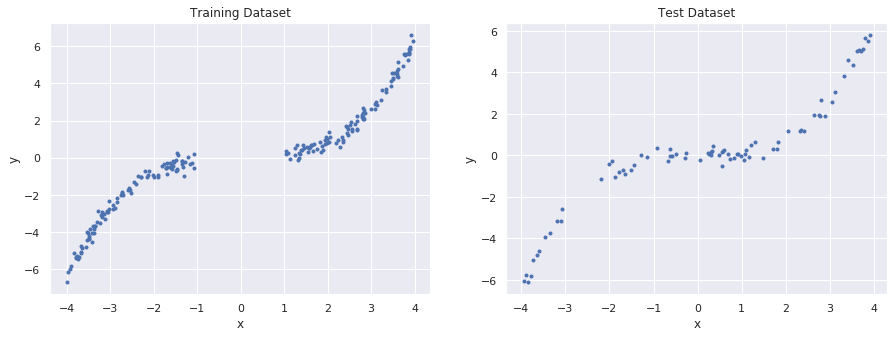

In [46]:
# your code here
fig, ax =plt.subplots(1,2, figsize=(15,5))
ax[0].plot(train[0], train[1], '.', label='train')
ax[0].set_title('Training Dataset')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].plot(test[0], test[1],'.', label='test')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Test Dataset');

**1.2** [2 pts] Create a fully connected neural network with 3 layers of 20 nodes each. Include dropout (using the Dropout class provided) before the last layer.


In [47]:
# https://github.com/keras-team/keras/issues/9412

class Dropout(layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=None, noise_shape=None, seed=None, **kwargs):
        super(Dropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

In [71]:
# create model 
# your code here 
fcnn = Sequential()

fcnn.add(Dense(20, activation='softmax', input_shape=(1,)))
fcnn.add(Dense(20, activation='softmax'))
fcnn.add(Dense(20, activation='softmax'))
fcnn.add(Dropout(0.1))
fcnn.add(Dense(1, activation='softmax'))

In [72]:
# Fit the model
# your code here


In [73]:
# evaluate the training and testing performance of your model 
# your code here


In [74]:
# plot 
# your code here 


**1.3** [2 pts] Train the network with dropout of 0.1, do inference for all the test points 10 times in training mode. From the outputs, find the model mean and standard variation. Repeat with dropoout of 0.2.


In [75]:
# your code here


In [76]:
# your code here


**1.4** [1 pt] Make a plot of the data, the model, and the uncertainty. Show the model mean and color the region of tow standard deviations.


In [80]:
# plot 
# your code here


**1.5** [2 pts] Turn dropout off (set it to 0) and train 50 models bootstrapping the training data. Doing statistics on the outputs, make a plot of the data, the model, and the uncertainty. Show the model mean and color the region tow standard deviations away, as in **1.3**


In [1]:
# define model 
# your code here 


In [103]:
# you may need this 
# from https://github.com/keras-team/keras/issues/341#issuecomment-438347068

def reset_weights(model):
    for layer in model.layers: 
        if isinstance(layer, tf.keras.Model):
            reset_weights(layer)
            continue
    for k, initializer in layer.__dict__.items():
        if "initializer" not in k:
            continue
        # find the corresponding variable
        var = getattr(layer, k.replace("_initializer", ""))
        var.assign(initializer(var.shape, var.dtype))

In [104]:
# Bootstrap and run model 
# your code here 


In [105]:
# your code here 


In [106]:
# plot 
# your code here 


**1.6** [2 pts] Compare both methods and discuss the pros and cons of each.


*Your answer here*